# Redes Neuronales RBF

In [1]:
params = {
    "learning_rate": 0.001,
    "momentum": 0.9,
    "acc": 0.0,
    "epoca": 0,
    "input_file": '/data/concentlite.csv',
    "EXP_NAME": 'EXP009',
    "MIN_ACC": 1.0,
    "MIN_ERROR": 1E6,
    "MAX_EPOCAS": 1000,
    "MAX_COUNTER": 50,
    "BATCH_SIZE": 10
}

In [17]:
import numpy as np
import os
import math
import time
import pandas as pd
import json
# NN
import torch
import torch.nn as nn
import torch.nn.functional as F
# RBF source model -----------------------
from src import torch_rbf as rbf
#from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch import optim
from copy import deepcopy
from sklearn.model_selection import train_test_split
## Ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
## Progress bar
from tqdm.notebook import tqdm
# Path
import sys
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()
## Check torch version
print(f'Using {torch.__version__}')


Using 2.0.0+cu117


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
torch.manual_seed(42)
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def load_split_save_data(input_filename, output_name='EXP', split_type='train_test', train_ratio=0.75, validate_ratio=None, test_ratio=None):

    data = pd.read_csv(input_filename)

    # Check if 'exp' folder exists, create it if it doesn't
    if not os.path.exists('exp'):
        os.makedirs('exp')
    
    # Create a subfolder with the output_name
    output_path = os.path.join('exp', output_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    if split_type == 'train_validate_test':
        if not validate_ratio or not test_ratio:
            raise ValueError("Please provide validate_ratio and test_ratio for 'train_validate_test' split type.")
        
        train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
        validate_data, test_data = train_test_split(temp_data, train_size=validate_ratio / (validate_ratio + test_ratio), random_state=42)
        
        # Save the train, validate, and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        validate_data.to_csv(os.path.join(output_path, f'{output_name}_validate_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, validate_data, test_data    

    elif split_type == 'train_test':
        train_data, test_data = train_test_split(data, train_size=train_ratio, random_state=42)
        
        # Save the train and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, test_data
    
    else:
        raise ValueError("Invalid split_type. Use either 'train_validate_test' or 'train_test'.")



In [5]:
class DATASET(Dataset):  
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=None).to_numpy() # Levanta los datos en formato numpy
        
        #------------------------------------
        # INSERTAMOS COLUMNA DEL "BIAS"
        #bias = -np.ones((len(data), 1))
        #data = np.concatenate((bias, data), axis=1)  # Insertamos el "bias" en la primera columna
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1].astype(np.float32)
        self.y = data[:,-1].astype(np.float32)  # La clase está en la última columna
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

In [6]:
def plot_scatter_with_labels(data):
    # Filter data by label
    data_label_1 = data[data[:, -1] == 1][:, 0:2]
    data_label_minus_1 = data[data[:, -1] == -1][:, 0:2]

    # Create scatter plots for each label
    plt.scatter(data_label_1[:, 0], data_label_1[:, 1], label='1', alpha=0.5)
    plt.scatter(data_label_minus_1[:, 0], data_label_minus_1[:, 1], label='-1', alpha=0.5)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Model1: NN + RBFLayer 

- source: https://github.com/rssalessio/PytorchRBFLayer

In [20]:
class MyDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)


In [18]:
class Network(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    
    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        self.train()
        obs = x.size(0)
        trainset = MyDataset(x, y)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()

In [10]:
# experiment
x1 = np.linspace(-1, 1, 101)
x2 = 0.5*np.cos(np.pi*x1) + 0.5*np.cos(4*np.pi*(x1+1)) # <- decision boundary

samples = 200
x = np.random.uniform(-1, 1, (samples, 2))
for i in range(samples):
    if i < samples//2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

steps = 100
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)


In [21]:
# Instanciating and training an RBF network with the Gaussian basis function
# This network receives a 2-dimensional input, transforms it into a 40-dimensional
# hidden representation with an RBF layer and then transforms that into a
# 1-dimensional output/prediction with a linear layer

# To add more layers, change the layer_widths and layer_centres lists

layer_widths = [2, 1]
layer_centres = [40]
basis_func = rbf.gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, 5000, samples, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()


Epoch: 5000, Progress: 200/200, Loss: 0.008272      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

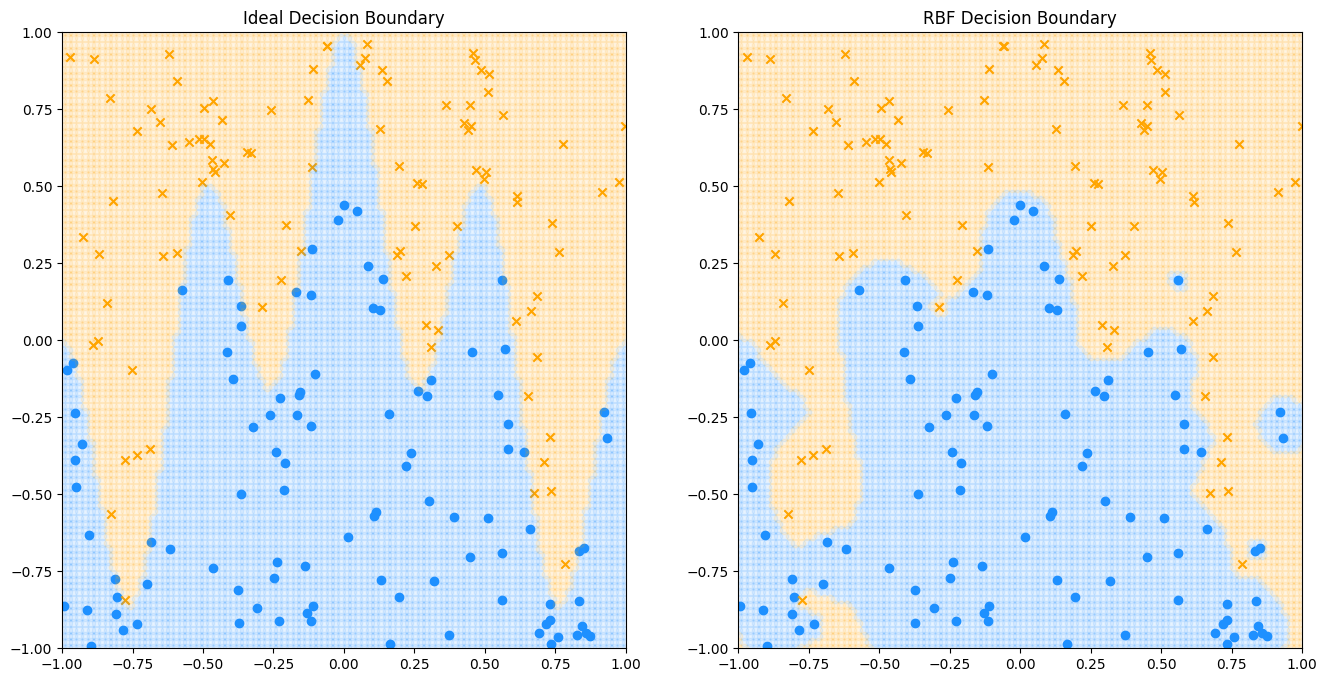

In [22]:
# Plotting the ideal and learned decision boundaries
with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()
ideal_0 = values[np.where(values[:,1] <= 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
ideal_1 = values[np.where(values[:,1] > 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='orange')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_title('Ideal Decision Boundary')
ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='orange')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-1,1])
ax[1].set_title('RBF Decision Boundary')
plt.show()

# Model2: RBFNet-Simple


In [6]:
import torch
import torch.nn as nn


class RBFNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_centers, sigma):
        super(RBFNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_centers = num_centers
        
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers, 1) / num_centers)
        self.sigma = sigma
        
        self.fc = nn.Linear(num_centers, output_dim)
    
    def radial_basis(self, x):
        C = self.centers.view(self.num_centers, -1)
        x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        H = self.radial_basis(x)
        out = self.fc(H)
        return out

In [9]:
input_dim = 10
hidden_dim = 100
output_dim = 2
num_centers = 20
sigma = 1.0

model = RBFNet(input_dim, hidden_dim, output_dim, num_centers, sigma)

x = torch.randn(32, input_dim)
output = model(x)
output[1]

tensor([ 0.0059, -0.1851], grad_fn=<SelectBackward0>)

In [63]:
def train_step(model, data, loss_function, optimizer, device):
    
    model.train()  # Calcula gradientes
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    #==============================================================
    for idx,(X,y) in enumerate(data):

        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()  # Se limpia el caché del optimizador
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)

        #----------------
        # Compute Loss
        #----------------
        if (data.batch_size == 1):
            loss = loss_function(y_pred.squeeze(), y.squeeze())
        else:
            loss = loss_function(y_pred.squeeze(), y)
        
        error += loss.item()
        
        #----------------
        # Backward pass
        #----------------
        loss.backward()
        optimizer.step()
    #==============================================================
    
    error /= N_batches
    
    return error, model

In [64]:
def predict_step(model, data, loss_function, device):
    
    model.eval()  # Turn off Dropouts Layers, BatchNorm Layers etc
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    #==============================================================
    with torch.no_grad():  # Turn off gradients computation
        
        for idx,(X,y) in enumerate(data):

            Y = torch.hstack( (Y, y.flatten()) )

            #-----------------------------------------------------
            # Convierto los datos en tensores diferenciables
            #-----------------------------------------------------
            X = X.to(device)
            y = y.to(device)

            #----------------
            # Forward pass
            #----------------
            y_pred = model(X)
            
            Yp = torch.hstack( (Yp, y_pred.flatten().cpu()) )

            #----------------
            # Compute Loss
            #----------------
            loss = loss_function(y_pred.squeeze(), y.squeeze())

            error += loss.item()
    #==============================================================
    
    error /= N_batches
    
    #------------------
    
    return error, Y, Yp

In [65]:
# Inicialize experiment
datafile = str(root) + params["input_file"]
train_data, test_data = load_split_save_data(datafile , output_name= params["EXP_NAME"])
# data
filename_train_data = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + '_train_data.csv'
filename_test_data = str(root) + '/exp/' + params["EXP_NAME"] + '/' +params["EXP_NAME"]  + '_test_data.csv'

# Construimos los datasets para entrenamiento y validación
trn = DATASET(filename_train_data)
test = DATASET(filename_test_data)

# Construimos los dataloaders para entrenamiento y validación
train_data = DataLoader(trn, batch_size=params["BATCH_SIZE"], shuffle=True)
validation_data = DataLoader(test, batch_size=params["BATCH_SIZE"], shuffle=False)

# Inicializamos el modelo
modelo = SimpleNN(num_inputs=2, num_outputs=1)
#modelo = L3NN(2, 64, 64, 64, 2)
modelo.to(device)

# Definimos la función de LOSS a utilizar
loss_function = nn.MSELoss(reduction='mean').to(device)
#loss_function = nn.BCELoss().to(device)
#loss_function = nn.BCEWithLogitsLoss().to(device)
#loss_function = nn.CrossEntropyLoss().to(device)

# Definimos el optimizador a utilizar
optimizer = optim.SGD(modelo.parameters(), lr=params["learning_rate"], momentum=params["momentum"])  # 0.9)
#optimizer = optim.Adam(modelo.parameters(), lr=learning_rate)

In [66]:
train_step(modelo, train_data, loss_function, optimizer, device)

(0.9461139227662768,
 SimpleNN(
   (linear1): Linear(in_features=2, out_features=3, bias=True)
   (act_fc1): Tanh()
   (linear2): Linear(in_features=3, out_features=1, bias=True)
   (act_fc2): Tanh()
 ))

In [ ]:
error = []   
accuracy = []  
STOP = False
counter = 0
best_model = None
best_model_weights = None

while (params["epoca"] < params["MAX_EPOCAS"]) and (params["acc"] < params["MIN_ACC"]) and (not STOP):

    params["epoca"] += 1
    
    # ENTRENAMIENTO    
    _,modelo = train_step(modelo, train_data, loss_function, optimizer, device)
    
    # VALIDACION    
    e,Y,Yp = predict_step(modelo, validation_data, loss_function, device)
    params["acc"] = torch.sum(Yp.sign() == Y.sign())/ len(Y)
    
    # ALMACENO MEDIDAS    
    error.append(e)
    accuracy.append(params["acc"])   
    
    # CRITERIO DE CORTE Y ALMACENAMIENTO DEL MODELO   
    if (e < params["MIN_ERROR"]):
        params["MIN_ERROR"] = e
        counter = 0
        
        
        # Almaceno el modelo        
        best_model = deepcopy(modelo)  # Genero una copia independiente
        best_model_weights = best_model.state_dict()
        
    else:
        counter += 1
        if counter > params["MAX_COUNTER"]:
            STOP = True
    
    
    # MUESTRO REPORTE POR PANTALLA (POR EPOCA)    
    if (params["epoca"] % 10) == 0:
        print('Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}\n'.format(params["epoca"], e, params["acc"]))

# MUESTRO REPORTE POR PANTALLA (FINAL)
print('='*79)
print('FINAL -- Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}'.format(params["epoca"], e, params["acc"]))
print('='*79)

# GUARDO MEJOR MODELO A DISCO
path_best_m = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + 'best_model.pt'
torch.save(best_model,
           path_best_m,
           _use_new_zipfile_serialization=True)        

# GUARDAMOS LOS PESOS DEL MEJOR MODELO A DISCO
path_best_m_state_dict = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + 'best_model_state_dict.pt'
torch.save(best_model.state_dict(),
           path_best_m_state_dict,
           _use_new_zipfile_serialization=True)

B = best_model.linear1.bias.detach().cpu().numpy()
W = best_model.linear1.weight.flatten().detach().cpu().numpy()
print(f'Bias: {B} -- W: {W}')

# Other training script

In [42]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter
# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard
# logging dir
loggingdir = str(root) + '/exp/' + params["EXP_NAME"] 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=params["MAX_EPOCAS"] , logging_dir=loggingdir):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for X, y in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = X.to(device)
            data_labels = y.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.x, val_dataset.y)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)
    
    writer.close()

In [45]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig


In [46]:
train_model_with_logger(modelo, optimizer, train_data, loss_function, val_dataset=test)

  0%|          | 0/1000 [00:00<?, ?it/s]